In [ ]:
# FedProx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import copy
import os
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_femnist_data(num_clients=100, iid_degree=0.1):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    full_dataset = datasets.EMNIST(
        root='./data',
        split='byclass',
        train=True,
        download=True,
        transform=transform
    )

    
    client_data = {i: {'x': [], 'y': []} for i in range(num_clients)}
    targets = full_dataset.targets.numpy()

    for class_idx in range(62):  
        class_indices = np.where(targets == class_idx)[0]
        np.random.shuffle(class_indices)

        proportions = np.random.dirichlet(np.repeat(iid_degree, num_clients))
        allocations = (proportions * len(class_indices)).astype(int)
        allocations[-1] = len(class_indices) - np.sum(allocations[:-1])

        start_idx = 0
        for client_id in range(num_clients):
            end_idx = start_idx + allocations[client_id]
            client_indices = class_indices[start_idx:end_idx]

            for idx in client_indices:
                img, label = full_dataset[idx]
                client_data[client_id]['x'].append(img)
                client_data[client_id]['y'].append(label)

            start_idx = end_idx

    client_loaders = {}
    for client_id, data in client_data.items():
        if len(data['x']) == 0:
            continue

        x_train, x_test, y_train, y_test = train_test_split(
            data['x'], data['y'], test_size=0.2, random_state=42
        )

        train_dataset = CustomDataset(x_train, y_train)
        test_dataset = CustomDataset(x_test, y_test)

        client_loaders[client_id] = {
            'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
            'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
        }

    return client_loaders

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class FemnistCNN(nn.Module):
    def __init__(self):
        super(FemnistCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7*7*64, 512)
        self.fc2 = nn.Linear(512, 62)  # 62个类别

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class FedProxClient:
    def __init__(self, client_id, train_loader, test_loader, device):
        self.client_id = client_id
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.model = FemnistCNN().to(device)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, global_model, mu, local_epochs, lr=0.01):
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()

        optimizer = optim.SGD(self.model.parameters(), lr=lr)

        train_loss = 0.0
        correct = 0
        total = 0

        for epoch in range(local_epochs):
            epoch_loss = 0.0
            for data, targets in self.train_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                optimizer.zero_grad()

                outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                proximal_term = 0.0
                for w, w_t in zip(self.model.parameters(), global_model.parameters()):
                    proximal_term += (w - w_t).norm(2)

                loss = loss + (mu / 2) * proximal_term

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            epoch_loss /= len(self.train_loader)
            train_loss += epoch_loss

        train_loss /= local_epochs
        train_acc = 100. * correct / total

        return copy.deepcopy(self.model.state_dict()), train_loss, train_acc

    def test(self, model=None):
        if model:
            self.model.load_state_dict(model)
        self.model.eval()

        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in self.test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_loss /= len(self.test_loader)
        test_acc = 100. * correct / total

        return test_loss, test_acc

# ======================
# FedProx server
# ======================
class FedProxServer:
    def __init__(self, num_clients, device, mu=0.1, dynamic_mu=False):
        self.global_model = FemnistCNN().to(device)
        self.device = device
        self.clients = []
        self.mu = mu
        self.dynamic_mu = dynamic_mu
        self.num_clients = num_clients

    def add_clients(self, client_loaders):
        for client_id, loaders in client_loaders.items():
            self.clients.append(FedProxClient(
                client_id,
                loaders['train'],
                loaders['test'],
                self.device
            ))

    def aggregate(self, client_updates):
        global_dict = self.global_model.state_dict()

        total_samples = sum([samples for _, samples, _ in client_updates])
        averaged_params = {}

        for key in global_dict.keys():
            averaged_params[key] = torch.zeros_like(global_dict[key])

        for model_state, samples, _ in client_updates:
            for key in model_state.keys():
                averaged_params[key] += model_state[key] * (samples / total_samples)

        self.global_model.load_state_dict(averaged_params)
        return averaged_params

    def select_clients(self, fraction=0.1):
        num_selected = max(int(self.num_clients * fraction), 1)
        return np.random.choice(self.clients, num_selected, replace=False)

    def adaptive_mu(self, round_idx, base_mu=0.1, decay_rate=0.98):
        if self.dynamic_mu:
            return base_mu * (decay_rate ** round_idx)
        return self.mu

    def evaluate_global_model(self, test_loader=None):
        self.global_model.eval()

        if test_loader:
            return self._centralized_eval(test_loader)
        else:
            return self._federated_eval()

    def _centralized_eval(self, test_loader):
        correct = 0
        total = 0
        test_loss = 0.0

        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.global_model(data)
                loss = F.cross_entropy(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        return test_loss, test_acc

    def _federated_eval(self):
        total_loss = 0.0
        total_acc = 0.0
        total_samples = 0

        for client in self.clients:
            samples = len(client.test_loader.dataset)
            loss, acc = client.test(self.global_model.state_dict())

            total_loss += loss * samples
            total_acc += acc * samples
            total_samples += samples

        avg_loss = total_loss / total_samples
        avg_acc = total_acc / total_samples
        return avg_loss, avg_acc

# ======================
# main function
# ======================
def main():
    num_rounds = 100
    num_clients = 100
    client_fraction = 0.1
    local_epochs = 5
    base_mu = 0.1
    dynamic_mu = True  

    print("Loading EMNIST data...")
    client_loaders = load_femnist_data(num_clients=num_clients, iid_degree=0.1)

    server = FedProxServer(
        num_clients=num_clients,
        device=device,
        mu=base_mu,
        dynamic_mu=dynamic_mu
    )
    server.add_clients(client_loaders)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    test_dataset = datasets.EMNIST(
        root='./data',
        split='byclass',
        train=False,
        download=True,
        transform=transform
    )
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    history = {
        'round': [],
        'mu': [],
        'global_loss': [],
        'global_acc': [],
        'client_losses': [],
        'client_accs': []
    }

    print("Starting Federated Training...")
    for round_idx in range(num_rounds):
        mu = server.adaptive_mu(round_idx, base_mu=base_mu)

        selected_clients = server.select_clients(fraction=client_fraction)
        print(f"Round {round_idx+1}/{num_rounds}, μ={mu:.4f}, Clients: {len(selected_clients)}")

        client_updates = []
        client_stats = {'loss': [], 'acc': []}

        for client in selected_clients:
            model_state, loss, acc = client.train(
                global_model=server.global_model,
                mu=mu,
                local_epochs=local_epochs,
                lr=0.01
            )
            samples = len(client.train_loader.dataset)
            client_updates.append((model_state, samples, client.client_id))
            client_stats['loss'].append(loss)
            client_stats['acc'].append(acc)

        server.aggregate(client_updates)

        global_loss, global_acc = server.evaluate_global_model(test_loader=test_loader)

        history['round'].append(round_idx)
        history['mu'].append(mu)
        history['global_loss'].append(global_loss)
        history['global_acc'].append(global_acc)
        history['client_losses'].append(client_stats['loss'])
        history['client_accs'].append(client_stats['acc'])

        print(f"Global Test - Loss: {global_loss:.4f}, Acc: {global_acc:.2f}%")
        print(f"Client Avg - Loss: {np.mean(client_stats['loss']):.4f}, Acc: {np.mean(client_stats['acc']):.2f}%")

    torch.save({
        'model': server.global_model.state_dict(),
        'history': history
    }, 'fedprox_femnist_results.pth')
    print("Training complete! Results saved.")

if __name__ == "__main__":
    main()

Loading FEMNIST data...
Starting Federated Training...
Round 1/100, μ=0.1000, Clients: 10
Global Test - Loss: 2.8573, Acc: 31.85%
Client Avg - Loss: 0.8899, Acc: 80.43%
Round 2/100, μ=0.0980, Clients: 10
Global Test - Loss: 1.8109, Acc: 54.45%
Client Avg - Loss: 0.5387, Acc: 86.60%
Round 3/100, μ=0.0960, Clients: 10
Global Test - Loss: 1.3468, Acc: 62.32%
Client Avg - Loss: 0.5571, Acc: 85.82%
Round 4/100, μ=0.0941, Clients: 10
Global Test - Loss: 1.0962, Acc: 67.97%
Client Avg - Loss: 0.3743, Acc: 89.81%
Round 5/100, μ=0.0922, Clients: 10
Global Test - Loss: 0.9456, Acc: 70.49%
Client Avg - Loss: 0.3309, Acc: 91.80%
Round 6/100, μ=0.0904, Clients: 10
Global Test - Loss: 0.9135, Acc: 70.99%
Client Avg - Loss: 0.2974, Acc: 92.20%
Round 7/100, μ=0.0886, Clients: 10
Global Test - Loss: 0.8129, Acc: 73.22%
Client Avg - Loss: 0.2276, Acc: 94.40%
Round 8/100, μ=0.0868, Clients: 10
Global Test - Loss: 0.8810, Acc: 72.15%
Client Avg - Loss: 0.2243, Acc: 94.54%
Round 9/100, μ=0.0851, Clients: 1

In [1]:
# FedAVG

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import random

# -----------------------------
# 1. Model Definition
# -----------------------------
class EMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 47)  # EMNIST Balanced has 47 classes
        )

    def forward(self, x):
        return self.fc(self.conv(x))

# -----------------------------
# 2. EMNIST Partitioning (Non-IID)
# -----------------------------
def partition_data(dataset, num_clients=100):
    labels = dataset.targets.numpy() if torch.is_tensor(dataset.targets) else np.array(dataset.targets)
    idx_by_class = [np.where(labels == i)[0] for i in range(47)]
    client_indices = [[] for _ in range(num_clients)]
    for c in range(47):
        np.random.shuffle(idx_by_class[c])
        parts = np.array_split(idx_by_class[c], num_clients)
        for i in range(num_clients):
            client_indices[i].extend(parts[i])
    return [Subset(dataset, inds) for inds in client_indices]

# -----------------------------
# 3. Client Class (FedAvg)
# -----------------------------
class Client:
    def __init__(self, model, data, lr, local_epochs, device):
        self.model = copy.deepcopy(model)
        self.data = data
        self.lr = lr
        self.local_epochs = local_epochs
        self.device = device

    def train(self, global_model):
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()

        optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(self.data, batch_size=32, shuffle=True)

        for epoch in range(self.local_epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                output = self.model(x)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()

        return copy.deepcopy(self.model.state_dict())
    
    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = criterion(output, y)
                total_loss += loss.item() * x.size(0)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return total_loss / total, correct / total

# -----------------------------
# 4. Server Class (FedAvg)
# -----------------------------
class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.clients = []
        self.num_clients = num_clients

    def add_clients(self, client_list):
        self.clients = client_list

    def aggregate(self, client_states):
        avg_state = copy.deepcopy(self.global_model.state_dict())
        for k in avg_state:
            avg_state[k] = sum(client[k] for client in client_states) / len(client_states)
        self.global_model.load_state_dict(avg_state)

    def federated_train(self, rounds):
        for r in range(rounds):
            round_start = time.time()
            selected = random.sample(self.clients, k=10)
            client_states = []

            print(f"Round {r+1}/{rounds}, Clients: {len(selected)}")

            for client in selected:
                state_dict = client.train(self.global_model)
                client_states.append(state_dict)

            self.aggregate(client_states)

            # 全部客户端用于评估
            global_losses, global_accs = [], []
            for client in self.clients:
                client.model.load_state_dict(self.global_model.state_dict())
                loss, acc = client.evaluate()
                global_losses.append(loss)
                global_accs.append(acc)

            avg_loss = np.mean(global_losses)
            avg_acc = np.mean(global_accs) * 100

            print(f"Global Test - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%")

# -----------------------------
# 5. Main Execution
# -----------------------------
def main():
    start_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("[0] Loading EMNIST...")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    emnist_train = datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=transform)
    print(f"[1] Dataset loaded. Total samples: {len(emnist_train)}")

    print("[2] Partitioning data...")
    partition_start = time.time()
    client_data = partition_data(emnist_train, num_clients=100)
    print(f"[3] Partition done in {time.time() - partition_start:.2f}s")

    print("[4] Initializing models...")
    global_model = EMNIST_CNN().to(device)
    server = Server(global_model, num_clients=100)
    clients = [Client(global_model, data, lr=0.001, local_epochs=2, device=device) for data in client_data]
    server.add_clients(clients)

    print("[5] Starting federated training...")
    server.federated_train(rounds=100)

    print(f"[6] Done. Total time: {time.time() - start_time:.2f}s")

if __name__ == '__main__':
    main()


Using device: cpu
[0] Loading EMNIST...
[1] Dataset loaded. Total samples: 112800
[2] Partitioning data...
[3] Partition done in 0.01s
[4] Initializing models...
[5] Starting federated training...
Round 1/100, Clients: 10
Global Test - Loss: 3.8508, Acc: 2.13%
Round 2/100, Clients: 10
Global Test - Loss: 3.8487, Acc: 2.21%
Round 3/100, Clients: 10
Global Test - Loss: 3.8466, Acc: 2.26%
Round 4/100, Clients: 10
Global Test - Loss: 3.8445, Acc: 2.30%
Round 5/100, Clients: 10
Global Test - Loss: 3.8425, Acc: 2.35%
Round 6/100, Clients: 10
Global Test - Loss: 3.8405, Acc: 2.43%
Round 7/100, Clients: 10
Global Test - Loss: 3.8386, Acc: 2.52%
Round 8/100, Clients: 10
Global Test - Loss: 3.8366, Acc: 2.62%
Round 9/100, Clients: 10
Global Test - Loss: 3.8346, Acc: 2.88%
Round 10/100, Clients: 10
Global Test - Loss: 3.8327, Acc: 3.11%
Round 11/100, Clients: 10
Global Test - Loss: 3.8308, Acc: 3.36%
Round 12/100, Clients: 10
Global Test - Loss: 3.8289, Acc: 3.67%
Round 13/100, Clients: 10
Global

In [1]:
# SCAFFOLD

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import random

# -----------------------------
# 1. Model Definition
# -----------------------------
class EMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 47)  # EMNIST Balanced has 47 classes
        )

    def forward(self, x):
        return self.fc(self.conv(x))

# -----------------------------
# 2. Partitioning (Non-IID)
# -----------------------------
def partition_data(dataset, num_clients=100):
    labels = dataset.targets.numpy() if torch.is_tensor(dataset.targets) else np.array(dataset.targets)
    idx_by_class = [np.where(labels == i)[0] for i in range(47)]
    client_indices = [[] for _ in range(num_clients)]
    for c in range(47):
        np.random.shuffle(idx_by_class[c])
        parts = np.array_split(idx_by_class[c], num_clients)
        for i in range(num_clients):
            client_indices[i].extend(parts[i])
    return [Subset(dataset, inds) for inds in client_indices]

# -----------------------------
# 3. Client Class (SCAFFOLD)
# -----------------------------
class Client:
    def __init__(self, model, data, lr, local_epochs, device):
        self.model = copy.deepcopy(model)
        self.data = data
        self.lr = lr
        self.local_epochs = local_epochs
        self.device = device
        self.ci = {k: torch.zeros_like(v) for k, v in self.model.state_dict().items()}

    def train(self, global_model, global_control):
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()

        optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(self.data, batch_size=32, shuffle=True)

        for epoch in range(self.local_epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                output = self.model(x)
                loss = criterion(output, y)

                # SCAFFOLD correction term
                control = torch.tensor(0.0, device=self.device)

                model_state = self.model.state_dict()
                global_state = global_model.state_dict()

                for name in model_state:
                    p = model_state[name]
                    w_t = global_state[name]
                    c = global_control[name]
                    ci = self.ci[name]
                    control += ((p - w_t) * (c - ci)).sum()

                loss += 0.5 * control

                loss.backward()
                optimizer.step()

        # Update local control variates
        delta_ci = {}
        with torch.no_grad():
            for k in self.model.state_dict().keys():
                delta = global_control[k] - self.ci[k] + \
                        (self.model.state_dict()[k] - global_model.state_dict()[k]) / (self.local_epochs * self.lr)
                delta_ci[k] = delta
                self.ci[k] += delta

        return copy.deepcopy(self.model.state_dict()), delta_ci

    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = criterion(output, y)
                total_loss += loss.item() * x.size(0)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return total_loss / total, correct / total

# -----------------------------
# 4. Server Class (SCAFFOLD)
# -----------------------------
class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.clients = []
        self.num_clients = num_clients
        self.global_control = {k: torch.zeros_like(v) for k, v in self.global_model.state_dict().items()}

    def add_clients(self, client_list):
        self.clients = client_list

    def aggregate(self, client_states):
        avg_state = copy.deepcopy(self.global_model.state_dict())
        for k in avg_state:
            avg_state[k] = sum(client[k] for client in client_states) / len(client_states)
        self.global_model.load_state_dict(avg_state)

    def update_control(self, delta_controls):
        for k in self.global_control:
            self.global_control[k] += sum(delta[k] for delta in delta_controls) / len(delta_controls)

    def federated_train(self, rounds):
        for r in range(rounds):
            selected = random.sample(self.clients, k=10)
            client_states, delta_controls = [], []

            print(f"Round {r+1}/{rounds}, Clients: {len(selected)}")

            for client in selected:
                state_dict, delta_ci = client.train(self.global_model, self.global_control)
                client_states.append(state_dict)
                delta_controls.append(delta_ci)

            self.aggregate(client_states)
            self.update_control(delta_controls)

            # Evaluate
            global_losses, global_accs = [], []
            for client in self.clients:
                client.model.load_state_dict(self.global_model.state_dict())
                loss, acc = client.evaluate()
                global_losses.append(loss)
                global_accs.append(acc)

            avg_loss = np.mean(global_losses)
            avg_acc = np.mean(global_accs) * 100

            print(f"Global Test - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%")

# -----------------------------
# 5. Main Execution
# -----------------------------
def main():
    start_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("[0] Loading EMNIST...")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    emnist_train = datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=transform)
    print(f"[1] Dataset loaded. Total samples: {len(emnist_train)}")

    print("[2] Partitioning data...")
    partition_start = time.time()
    client_data = partition_data(emnist_train, num_clients=100)
    print(f"[3] Partition done in {time.time() - partition_start:.2f}s")

    print("[4] Initializing models...")
    global_model = EMNIST_CNN().to(device)
    server = Server(global_model, num_clients=100)
    clients = [Client(global_model, data, lr=0.001, local_epochs=2, device=device) for data in client_data]
    server.add_clients(clients)

    print("[5] Starting federated training...")
    server.federated_train(rounds=100)

    print(f"[6] Done. Total time: {time.time() - start_time:.2f}s")

if __name__ == '__main__':
    main()


Using device: cpu
[0] Loading EMNIST...
[1] Dataset loaded. Total samples: 112800
[2] Partitioning data...
[3] Partition done in 0.01s
[4] Initializing models...
[5] Starting federated training...
Round 1/100, Clients: 10
Global Test - Loss: 3.8496, Acc: 2.36%
Round 2/100, Clients: 10
Global Test - Loss: 3.8472, Acc: 2.67%
Round 3/100, Clients: 10
Global Test - Loss: 3.8450, Acc: 3.01%
Round 4/100, Clients: 10
Global Test - Loss: 3.8428, Acc: 3.36%
Round 5/100, Clients: 10
Global Test - Loss: 3.8407, Acc: 3.77%
Round 6/100, Clients: 10
Global Test - Loss: 3.8387, Acc: 4.24%
Round 7/100, Clients: 10
Global Test - Loss: 3.8366, Acc: 4.68%
Round 8/100, Clients: 10
Global Test - Loss: 3.8345, Acc: 5.09%
Round 9/100, Clients: 10
Global Test - Loss: 3.8324, Acc: 5.47%
Round 10/100, Clients: 10
Global Test - Loss: 3.8303, Acc: 5.83%
Round 11/100, Clients: 10
Global Test - Loss: 3.8281, Acc: 6.22%
Round 12/100, Clients: 10
Global Test - Loss: 3.8259, Acc: 6.61%
Round 13/100, Clients: 10
Global

In [3]:
# FedICT

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import random

# -----------------------------
# 1. Model Definition
# -----------------------------
class EMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 47)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

# -----------------------------
# 2. Partitioning (Non-IID)
# -----------------------------
def partition_data(dataset, num_clients=100):
    labels = dataset.targets.numpy() if torch.is_tensor(dataset.targets) else np.array(dataset.targets)
    idx_by_class = [np.where(labels == i)[0] for i in range(47)]
    client_indices = [[] for _ in range(num_clients)]
    for c in range(47):
        np.random.shuffle(idx_by_class[c])
        parts = np.array_split(idx_by_class[c], num_clients)
        for i in range(num_clients):
            client_indices[i].extend(parts[i])
    return [Subset(dataset, inds) for inds in client_indices]

# -----------------------------
# 3. Client Class (FedICT)
# -----------------------------
class Client:
    def __init__(self, model, data, lr, local_epochs, device):
        self.model = copy.deepcopy(model)
        self.data = data
        self.lr = lr
        self.local_epochs = local_epochs
        self.device = device

    def local_train(self):
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(self.data, batch_size=32, shuffle=True)

        for epoch in range(self.local_epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                output = self.model(x)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()

        return copy.deepcopy(self.model.state_dict())

    def get_logits(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        all_logits, all_targets = [], []

        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                logits = self.model(x)
                all_logits.append(logits.cpu())
                all_targets.append(y)

        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        return all_logits, all_targets

    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = criterion(output, y)
                total_loss += loss.item() * x.size(0)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return total_loss / total, correct / total

# -----------------------------
# 4. Server Class (FedICT)
# -----------------------------
class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.clients = []
        self.num_clients = num_clients

    def add_clients(self, client_list):
        self.clients = client_list

    def federated_train(self, rounds):
        for r in range(rounds):
            selected = random.sample(self.clients, k=10)
            client_states = []
            all_logits, all_targets, all_images = [], [], []

            print(f"Round {r+1}/{rounds}, Clients: {len(selected)}")

            # Local training and get logits
            for client in selected:
                state_dict = client.local_train()
                client_states.append(state_dict)

                client.model.load_state_dict(state_dict)
                logits, targets = client.get_logits()
                all_logits.append(logits)
                all_targets.append(targets)

                # 收集原始图片
                for x, _ in DataLoader(client.data, batch_size=64, shuffle=False):
                    all_images.append(x)

            # Aggregate pseudo labels (soft distillation)
            concat_logits = torch.cat(all_logits, dim=0)
            pseudo_labels = concat_logits.softmax(dim=1)

            images_tensor = torch.cat(all_images, dim=0)

            # Create loader for distillation
            loader = DataLoader(torch.utils.data.TensorDataset(images_tensor, pseudo_labels), batch_size=64, shuffle=True)

            # Train global model using images + soft labels
            self.global_model.train()
            optimizer = optim.SGD(self.global_model.parameters(), lr=0.001)

            for x, soft_y in loader:
                x = x.to(self.global_model.fc[-1].weight.device)
                soft_y = soft_y.to(self.global_model.fc[-1].weight.device)

                optimizer.zero_grad()
                output = self.global_model(x)
                loss = nn.KLDivLoss(reduction="batchmean")(output.log_softmax(dim=1), soft_y)
                loss.backward()
                optimizer.step()

            # Evaluate
            global_losses, global_accs = [], []
            for client in self.clients:
                client.model.load_state_dict(self.global_model.state_dict())
                loss, acc = client.evaluate()
                global_losses.append(loss)
                global_accs.append(acc)

            avg_loss = np.mean(global_losses)
            avg_acc = np.mean(global_accs) * 100

            print(f"Global Test - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%")


# -----------------------------
# 5. Main Execution
# -----------------------------
def main():
    start_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("[0] Loading EMNIST...")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    emnist_train = datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=transform)
    print(f"[1] Dataset loaded. Total samples: {len(emnist_train)}")

    print("[2] Partitioning data...")
    partition_start = time.time()
    client_data = partition_data(emnist_train, num_clients=100)
    print(f"[3] Partition done in {time.time() - partition_start:.2f}s")

    print("[4] Initializing models...")
    global_model = EMNIST_CNN().to(device)
    server = Server(global_model, num_clients=100)
    clients = [Client(global_model, data, lr=0.001, local_epochs=2, device=device) for data in client_data]
    server.add_clients(clients)

    print("[5] Starting federated training...")
    server.federated_train(rounds=100)

    print(f"[6] Done. Total time: {time.time() - start_time:.2f}s")

if __name__ == '__main__':
    main()


Using device: cpu
[0] Loading EMNIST...
[1] Dataset loaded. Total samples: 112800
[2] Partitioning data...
[3] Partition done in 0.01s
[4] Initializing models...
[5] Starting federated training...
Round 1/100, Clients: 10
Global Test - Loss: 3.8537, Acc: 2.74%
Round 2/100, Clients: 10
Global Test - Loss: 3.8537, Acc: 2.75%
Round 3/100, Clients: 10
Global Test - Loss: 3.8537, Acc: 2.77%
Round 4/100, Clients: 10
Global Test - Loss: 3.8536, Acc: 2.79%
Round 5/100, Clients: 10
Global Test - Loss: 3.8536, Acc: 2.80%
Round 6/100, Clients: 10
Global Test - Loss: 3.8536, Acc: 2.81%
Round 7/100, Clients: 10
Global Test - Loss: 3.8535, Acc: 2.82%
Round 8/100, Clients: 10
Global Test - Loss: 3.8535, Acc: 2.84%
Round 9/100, Clients: 10
Global Test - Loss: 3.8535, Acc: 2.86%
Round 10/100, Clients: 10
Global Test - Loss: 3.8534, Acc: 2.88%
Round 11/100, Clients: 10
Global Test - Loss: 3.8534, Acc: 2.89%
Round 12/100, Clients: 10
Global Test - Loss: 3.8534, Acc: 2.91%
Round 13/100, Clients: 10
Global

In [1]:
# FedDyn-DF

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import random

# -----------------------------
# 1. Model Definition
# -----------------------------
class EMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 47)  # EMNIST Balanced has 47 classes
        )

    def forward(self, x):
        return self.fc(self.conv(x))

# -----------------------------
# 2. Partitioning (Non-IID)
# -----------------------------
def partition_data(dataset, num_clients=100):
    labels = dataset.targets.numpy() if torch.is_tensor(dataset.targets) else np.array(dataset.targets)
    idx_by_class = [np.where(labels == i)[0] for i in range(47)]
    client_indices = [[] for _ in range(num_clients)]
    for c in range(47):
        np.random.shuffle(idx_by_class[c])
        parts = np.array_split(idx_by_class[c], num_clients)
        for i in range(num_clients):
            client_indices[i].extend(parts[i])
    return [Subset(dataset, inds) for inds in client_indices]

# -----------------------------
# 3. Client Class (FedDyn-DF)
# -----------------------------
class Client:
    def __init__(self, model, data, lr, local_epochs, device):
        self.model = copy.deepcopy(model)
        self.data = data
        self.lr = lr
        self.local_epochs = local_epochs
        self.device = device
        # Dynamic correction vector (tracker)
        self.dyn_vector = {k: torch.zeros_like(v) for k, v in self.model.state_dict().items()}

    def train(self, global_model):
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()

        optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(self.data, batch_size=32, shuffle=True)

        for epoch in range(self.local_epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                output = self.model(x)
                loss = criterion(output, y)

                # FedDyn correction term
                correction = 0.0
                local_state = self.model.state_dict()
                for name in local_state:
                    p = local_state[name]
                    dyn = self.dyn_vector[name]
                    correction += (p * dyn).sum()

                loss += correction

                loss.backward()
                optimizer.step()

        # Update dynamic correction vector
        with torch.no_grad():
            for k in self.model.state_dict().keys():
                delta = global_model.state_dict()[k] - self.model.state_dict()[k]
                self.dyn_vector[k] -= delta / (self.lr * self.local_epochs)

        return copy.deepcopy(self.model.state_dict())

    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = criterion(output, y)
                total_loss += loss.item() * x.size(0)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return total_loss / total, correct / total

# -----------------------------
# 4. Server Class (FedDyn-DF)
# -----------------------------
class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.clients = []
        self.num_clients = num_clients

    def add_clients(self, client_list):
        self.clients = client_list

    def aggregate(self, client_states):
        avg_state = copy.deepcopy(self.global_model.state_dict())
        for k in avg_state:
            avg_state[k] = sum(client[k] for client in client_states) / len(client_states)
        self.global_model.load_state_dict(avg_state)

    def federated_train(self, rounds):
        for r in range(rounds):
            selected = random.sample(self.clients, k=10)
            client_states = []

            print(f"Round {r+1}/{rounds}, Clients: {len(selected)}")

            for client in selected:
                state_dict = client.train(self.global_model)
                client_states.append(state_dict)

            self.aggregate(client_states)

            # Evaluate
            global_losses, global_accs = [], []
            for client in self.clients:
                client.model.load_state_dict(self.global_model.state_dict())
                loss, acc = client.evaluate()
                global_losses.append(loss)
                global_accs.append(acc)

            avg_loss = np.mean(global_losses)
            avg_acc = np.mean(global_accs) * 100

            print(f"Global Test - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%")

# -----------------------------
# 5. Main Execution
# -----------------------------
def main():
    start_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("[0] Loading EMNIST...")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    emnist_train = datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=transform)
    print(f"[1] Dataset loaded. Total samples: {len(emnist_train)}")

    print("[2] Partitioning data...")
    partition_start = time.time()
    client_data = partition_data(emnist_train, num_clients=100)
    print(f"[3] Partition done in {time.time() - partition_start:.2f}s")

    print("[4] Initializing models...")
    global_model = EMNIST_CNN().to(device)
    server = Server(global_model, num_clients=100)
    clients = [Client(global_model, data, lr=0.001, local_epochs=2, device=device) for data in client_data]
    server.add_clients(clients)

    print("[5] Starting federated training...")
    server.federated_train(rounds=100)

    print(f"[6] Done. Total time: {time.time() - start_time:.2f}s")

if __name__ == '__main__':
    main()


Using device: cpu
[0] Loading EMNIST...
[1] Dataset loaded. Total samples: 112800
[2] Partitioning data...
[3] Partition done in 0.01s
[4] Initializing models...
[5] Starting federated training...
Round 1/100, Clients: 10
Global Test - Loss: 3.8527, Acc: 2.01%
Round 2/100, Clients: 10
Global Test - Loss: 3.8515, Acc: 2.03%
Round 3/100, Clients: 10
Global Test - Loss: 3.8503, Acc: 2.06%
Round 4/100, Clients: 10
Global Test - Loss: 3.8492, Acc: 2.09%
Round 5/100, Clients: 10
Global Test - Loss: 3.8482, Acc: 2.14%
Round 6/100, Clients: 10
Global Test - Loss: 3.8472, Acc: 2.20%
Round 7/100, Clients: 10
Global Test - Loss: 3.8463, Acc: 2.30%
Round 8/100, Clients: 10
Global Test - Loss: 3.8454, Acc: 2.46%
Round 9/100, Clients: 10
Global Test - Loss: 3.8445, Acc: 2.64%
Round 10/100, Clients: 10
Global Test - Loss: 3.8436, Acc: 2.88%
Round 11/100, Clients: 10
Global Test - Loss: 3.8426, Acc: 3.11%
Round 12/100, Clients: 10
Global Test - Loss: 3.8417, Acc: 3.36%
Round 13/100, Clients: 10
Global

In [2]:
# FedSC-MTL
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import random

# -----------------------------
# 1. Model Definition
# -----------------------------
class EMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(64*5*5, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 47)

    def forward(self, x, return_features=False):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        feat = self.relu(self.fc1(x))
        out = self.fc2(feat)
        if return_features:
            return out, feat
        else:
            return out

# -----------------------------
# 2. Partitioning (Non-IID)
# -----------------------------
def partition_data(dataset, num_clients=100):
    labels = dataset.targets.numpy() if torch.is_tensor(dataset.targets) else np.array(dataset.targets)
    idx_by_class = [np.where(labels == i)[0] for i in range(47)]
    client_indices = [[] for _ in range(num_clients)]
    for c in range(47):
        np.random.shuffle(idx_by_class[c])
        parts = np.array_split(idx_by_class[c], num_clients)
        for i in range(num_clients):
            client_indices[i].extend(parts[i])
    return [Subset(dataset, inds) for inds in client_indices]

# -----------------------------
# 3. Client Class (FedSC-MTL)
# -----------------------------
class Client:
    def __init__(self, model, data, lr, local_epochs, device):
        self.model = copy.deepcopy(model)
        self.data = data
        self.lr = lr
        self.local_epochs = local_epochs
        self.device = device
        self.ci = {k: torch.zeros_like(v) for k, v in self.model.state_dict().items()}

    def train(self, global_model, cg, mu):
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()

        optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(self.data, batch_size=32, shuffle=True)

        for epoch in range(self.local_epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()

                output, feat = self.model(x, return_features=True)
                loss_cls = criterion(output, y)

                # 特征蒸馏损失（这里以零向量作为参考特征示例，你可根据实际替换）
                fref = torch.zeros_like(feat).to(self.device)
                distill_loss = nn.MSELoss()(feat, fref)

                # 控制变量修正项
                grad_correction = 0.0
                model_state = self.model.state_dict()
                global_state = global_model.state_dict()

                for name in model_state:
                    p = model_state[name]
                    w_t = global_state[name]
                    c_global = cg[name]
                    ci_local = self.ci[name]
                    grad_correction += ((p - w_t) * (-ci_local + c_global + mu * (p - w_t))).sum()

                # 合并总损失
                total_loss = loss_cls + distill_loss + 0.5 * grad_correction

                total_loss.backward()
                optimizer.step()

        # 更新 local control ci
        with torch.no_grad():
            for k in self.model.state_dict().keys():
                self.ci[k] = self.ci[k] - cg[k] + (global_model.state_dict()[k] - self.model.state_dict()[k]) / self.lr

        return copy.deepcopy(self.model.state_dict()), self.ci


    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = criterion(output, y)
                total_loss += loss.item() * x.size(0)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return total_loss / total, correct / total

# -----------------------------
# 4. Server Class (FedSC-MTL)
# -----------------------------
class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.clients = []
        self.num_clients = num_clients
        self.cg = {k: torch.zeros_like(v) for k, v in self.global_model.state_dict().items()}

    def add_clients(self, client_list):
        self.clients = client_list

    def aggregate(self, client_states):
        avg_state = copy.deepcopy(self.global_model.state_dict())
        for k in avg_state:
            avg_state[k] = sum(client[k] for client in client_states) / len(client_states)
        self.global_model.load_state_dict(avg_state)

    def update_cg(self, ci_list):
        for k in self.cg:
            self.cg[k] = sum(ci[k] for ci in ci_list) / len(ci_list)

    def federated_train(self, rounds, mu_scheduler):
        for r in range(rounds):
            selected = random.sample(self.clients, k=10)
            mu = mu_scheduler(r)
            client_states, ci_list = [], []

            print(f"Round {r+1}/{rounds}, μ={mu:.4f}, Clients: {len(selected)}")

            for client in selected:
                state_dict, ci = client.train(self.global_model, self.cg, mu)
                client_states.append(state_dict)
                ci_list.append(ci)

            self.aggregate(client_states)
            self.update_cg(ci_list)

            # Evaluate
            global_losses, global_accs = [], []
            for client in self.clients:
                client.model.load_state_dict(self.global_model.state_dict())
                loss, acc = client.evaluate()
                global_losses.append(loss)
                global_accs.append(acc)

            avg_loss = np.mean(global_losses)
            avg_acc = np.mean(global_accs) * 100

            print(f"Global Test - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%")

# -----------------------------
# 5. Main Execution
# -----------------------------
def main():
    start_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("[0] Loading EMNIST...")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    emnist_train = datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=transform)
    print(f"[1] Dataset loaded. Total samples: {len(emnist_train)}")

    print("[2] Partitioning data...")
    partition_start = time.time()
    client_data = partition_data(emnist_train, num_clients=100)
    print(f"[3] Partition done in {time.time() - partition_start:.2f}s")

    print("[4] Initializing models...")
    global_model = EMNIST_CNN().to(device)
    server = Server(global_model, num_clients=100)
    clients = [Client(global_model, data, lr=0.001, local_epochs=2, device=device) for data in client_data]
    server.add_clients(clients)

    def mu_schedule(round_idx):
        return 0.1 * (0.95 ** (round_idx // 10))  # 每10轮衰减

    print("[5] Starting federated training...")
    server.federated_train(rounds=100, mu_scheduler=mu_schedule)

    print(f"[6] Done. Total time: {time.time() - start_time:.2f}s")

if __name__ == '__main__':
    main()


Using device: cpu
[0] Loading EMNIST...
[1] Dataset loaded. Total samples: 112800
[2] Partitioning data...
[3] Partition done in 0.02s
[4] Initializing models...
[5] Starting federated training...
Round 1/100, μ=0.1000, Clients: 10
Global Test - Loss: 3.8506, Acc: 2.76%
Round 2/100, μ=0.1000, Clients: 10
Global Test - Loss: 3.8491, Acc: 2.96%
Round 3/100, μ=0.1000, Clients: 10
Global Test - Loss: 3.8477, Acc: 3.18%
Round 4/100, μ=0.1000, Clients: 10
Global Test - Loss: 3.8464, Acc: 3.47%
Round 5/100, μ=0.1000, Clients: 10
Global Test - Loss: 3.8452, Acc: 3.77%
Round 6/100, μ=0.1000, Clients: 10
Global Test - Loss: 3.8441, Acc: 4.00%
Round 7/100, μ=0.1000, Clients: 10
Global Test - Loss: 3.8430, Acc: 4.25%
Round 8/100, μ=0.1000, Clients: 10
Global Test - Loss: 3.8420, Acc: 4.43%
Round 9/100, μ=0.1000, Clients: 10
Global Test - Loss: 3.8409, Acc: 4.59%
Round 10/100, μ=0.1000, Clients: 10
Global Test - Loss: 3.8399, Acc: 4.67%
Round 11/100, μ=0.0950, Clients: 10
Global Test - Loss: 3.8389

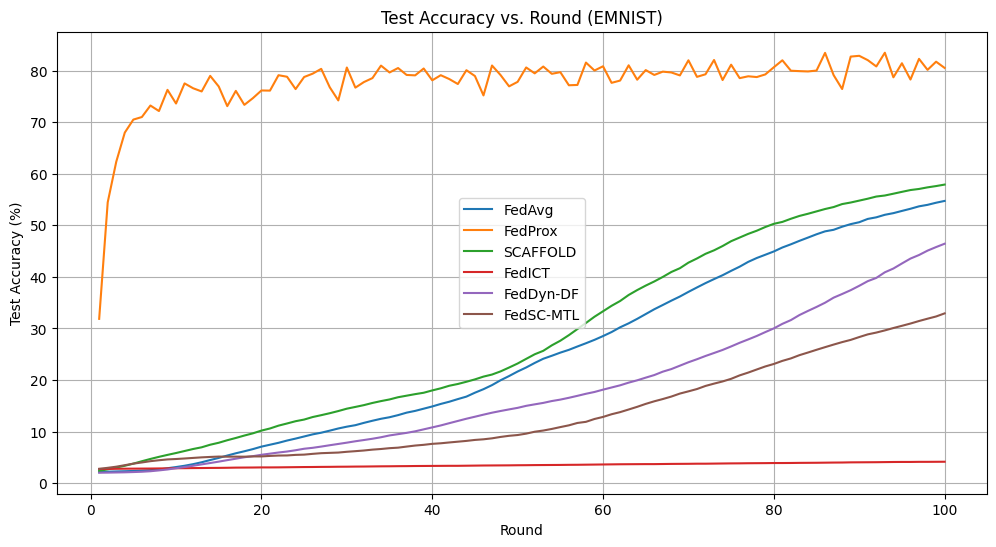

In [3]:
import matplotlib.pyplot as plt


fedavg_acc = [
    2.13, 2.21, 2.26, 2.30, 2.35, 2.43, 2.52, 2.62, 2.88, 3.11,
    3.36, 3.67, 4.04, 4.47, 4.88, 5.34, 5.78, 6.17, 6.59, 7.07,
    7.44, 7.81, 8.25, 8.63, 9.04, 9.45, 9.77, 10.17, 10.59, 10.94,
    11.23, 11.68, 12.09, 12.47, 12.77, 13.18, 13.66, 14.00, 14.43, 14.86,
    15.35, 15.78, 16.29, 16.77, 17.53, 18.21, 19.00, 19.94, 20.76, 21.64,
    22.42, 23.30, 24.11, 24.69, 25.30, 25.84, 26.49, 27.12, 27.78, 28.51,
    29.29, 30.21, 30.98, 31.85, 32.78, 33.71, 34.54, 35.38, 36.18, 37.08,
    37.94, 38.78, 39.56, 40.31, 41.16, 41.97, 42.90, 43.65, 44.28, 44.92,
    45.69, 46.31, 46.98, 47.61, 48.25, 48.82, 49.12, 49.72, 50.22, 50.59,
    51.23, 51.54, 52.03, 52.35, 52.78, 53.20, 53.67, 53.96, 54.37, 54.72
]

# FedProx 数据
fedprox_acc = [
    31.85, 54.45, 62.32, 67.97, 70.49, 70.99, 73.22, 72.15, 76.26, 73.61,
    77.51, 76.57, 75.95, 78.97, 76.91, 73.10, 76.06, 73.35, 74.65, 76.14,
    76.11, 79.10, 78.80, 76.41, 78.75, 79.40, 80.33, 76.76, 74.21, 80.59,
    76.69, 77.77, 78.54, 80.96, 79.63, 80.49, 79.15, 79.07, 80.40, 78.11,
    79.10, 78.35, 77.39, 80.07, 78.94, 75.18, 80.98, 79.13, 76.94, 77.81,
    80.60, 79.46, 80.78, 79.37, 79.69, 77.15, 77.21, 81.55, 80.01, 80.83,
    77.62, 78.06, 81.02, 78.23, 80.09, 79.15, 79.79, 79.63, 79.06, 81.99,
    78.78, 79.28, 82.05, 78.16, 81.14, 78.53, 78.89, 78.74, 79.25, 80.64,
    81.99, 79.97, 79.89, 79.83, 80.00, 83.43, 79.12, 76.42, 82.71, 82.86,
    82.02, 80.80, 83.46, 78.69, 81.42, 78.26, 82.27, 80.14, 81.72, 80.51
]

# SCAFFOLD 数据
scaffold_acc = [
    2.36, 2.67, 3.01, 3.36, 3.77, 4.24, 4.68, 5.09, 5.47, 5.83,
    6.22, 6.61, 6.94, 7.44, 7.82, 8.31, 8.75, 9.22, 9.65, 10.18,
    10.59, 11.14, 11.56, 12.00, 12.32, 12.81, 13.17, 13.55, 13.97, 14.43,
    14.77, 15.12, 15.54, 15.90, 16.22, 16.65, 16.95, 17.25, 17.52, 17.97,
    18.38, 18.88, 19.22, 19.65, 20.11, 20.65, 21.05, 21.66, 22.41, 23.19,
    24.09, 24.98, 25.65, 26.71, 27.61, 28.69, 29.87, 31.05, 32.26, 33.32,
    34.38, 35.31, 36.48, 37.43, 38.30, 39.10, 39.98, 40.94, 41.67, 42.75,
    43.56, 44.46, 45.14, 45.97, 46.91, 47.62, 48.33, 48.94, 49.66, 50.28,
    50.65, 51.26, 51.81, 52.23, 52.69, 53.15, 53.53, 54.11, 54.41, 54.78,
    55.15, 55.57, 55.77, 56.12, 56.48, 56.83, 57.04, 57.35, 57.60, 57.89
]

fedict_acc = [
    2.74, 2.75, 2.77, 2.79, 2.80, 2.81, 2.82, 2.84, 2.86, 2.88,
    2.89, 2.91, 2.92, 2.94, 2.95, 2.97, 3.00, 3.01, 3.02, 3.04,
    3.04, 3.05, 3.07, 3.09, 3.11, 3.12, 3.14, 3.15, 3.17, 3.18,
    3.20, 3.21, 3.23, 3.25, 3.26, 3.28, 3.29, 3.31, 3.32, 3.33,
    3.34, 3.35, 3.35, 3.37, 3.39, 3.41, 3.42, 3.43, 3.44, 3.46,
    3.47, 3.49, 3.50, 3.51, 3.52, 3.54, 3.55, 3.57, 3.59, 3.61,
    3.63, 3.65, 3.66, 3.67, 3.68, 3.68, 3.70, 3.72, 3.73, 3.74,
    3.76, 3.76, 3.78, 3.80, 3.82, 3.83, 3.85, 3.86, 3.87, 3.89,
    3.89, 3.90, 3.92, 3.93, 3.94, 3.96, 3.98, 3.99, 4.02, 4.03,
    4.04, 4.05, 4.07, 4.09, 4.10, 4.10, 4.12, 4.12, 4.13, 4.14
]

feddyn_df_acc = [
    2.01, 2.03, 2.06, 2.09, 2.14, 2.20, 2.30, 2.46, 2.64, 2.88,
    3.11, 3.36, 3.63, 3.89, 4.16, 4.45, 4.73, 5.01, 5.22, 5.49,
    5.71, 5.93, 6.12, 6.37, 6.66, 6.84, 7.08, 7.34, 7.59, 7.84,
    8.11, 8.35, 8.60, 8.89, 9.24, 9.49, 9.74, 10.04, 10.42, 10.80,
    11.18, 11.62, 12.05, 12.48, 12.87, 13.27, 13.65, 13.98, 14.29, 14.59,
    14.98, 15.27, 15.55, 15.91, 16.19, 16.54, 16.92, 17.32, 17.67, 18.12,
    18.54, 18.96, 19.48, 19.93, 20.45, 20.95, 21.61, 22.11, 22.77, 23.43,
    24.02, 24.65, 25.23, 25.82, 26.50, 27.21, 27.86, 28.53, 29.28, 30.00,
    30.88, 31.61, 32.59, 33.39, 34.16, 34.98, 35.96, 36.67, 37.41, 38.26,
    39.16, 39.79, 40.88, 41.61, 42.59, 43.54, 44.23, 45.08, 45.77, 46.42
]

fedsc_mtl_acc = [
    2.76, 2.96, 3.18, 3.47, 3.77, 4.00, 4.25, 4.43, 4.59, 4.67,
    4.77, 4.88, 4.99, 5.07, 5.14, 5.12, 5.13, 5.12, 5.17, 5.17,
    5.27, 5.34, 5.36, 5.47, 5.52, 5.67, 5.80, 5.86, 5.92, 6.07,
    6.19, 6.32, 6.49, 6.61, 6.77, 6.87, 7.08, 7.28, 7.42, 7.61,
    7.72, 7.88, 8.03, 8.18, 8.37, 8.49, 8.68, 8.95, 9.17, 9.32,
    9.59, 9.96, 10.19, 10.50, 10.86, 11.20, 11.66, 11.88, 12.43, 12.83,
    13.35, 13.76, 14.27, 14.79, 15.36, 15.86, 16.30, 16.78, 17.36, 17.79,
    18.24, 18.84, 19.29, 19.71, 20.22, 20.89, 21.43, 22.03, 22.62, 23.10,
    23.70, 24.18, 24.81, 25.32, 25.85, 26.36, 26.86, 27.34, 27.77, 28.32,
    28.84, 29.19, 29.61, 30.07, 30.50, 30.94, 31.43, 31.88, 32.31, 32.91
]



rounds = list(range(1, 101))

plt.figure(figsize=(12, 6))
plt.plot(rounds, fedavg_acc, label='FedAvg')
plt.plot(rounds, fedprox_acc, label='FedProx')
plt.plot(rounds, scaffold_acc, label='SCAFFOLD')
plt.plot(rounds, fedict_acc, label='FedICT')
plt.plot(rounds, feddyn_df_acc, label='FedDyn-DF')
plt.plot(rounds, fedsc_mtl_acc, label='FedSC-MTL')

plt.xlabel('Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs. Round (EMNIST)')
plt.legend()
plt.grid(True)
plt.show()